importing the dataset to notebook environment

In [5]:
import pandas as pd
essay_df = pd.read_csv(filepath_or_buffer="/train_essays.csv")

In [6]:
print(f"Column Names: {essay_df.columns}")

Column Names: Index(['id', 'prompt_id', 'text', 'generated'], dtype='object')


In [7]:
print(f"shape of the Dataframe: {essay_df.shape}")

shape of the Dataframe: (1378, 4)


In [8]:
print(f"Datatypes and Non-null coounts: {essay_df.info()}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1378 entries, 0 to 1377
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         1378 non-null   object
 1   prompt_id  1378 non-null   int64 
 2   text       1378 non-null   object
 3   generated  1378 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 43.2+ KB
Datatypes and Non-null coounts: None


In [9]:
print(f"number of duplicated records: {essay_df.duplicated().sum()}")

number of duplicated records: 0


In [10]:
print(f"Statistical summary of the numerical columns \n {essay_df.describe()}")

Statistical summary of the numerical columns 
          prompt_id    generated
count  1378.000000  1378.000000
mean      0.486212     0.002177
std       0.499991     0.046625
min       0.000000     0.000000
25%       0.000000     0.000000
50%       0.000000     0.000000
75%       1.000000     0.000000
max       1.000000     1.000000


In [11]:
print(essay_df.isna().sum())

id           0
prompt_id    0
text         0
generated    0
dtype: int64


In [12]:
categorical_cols = essay_df.select_dtypes(include='object')

In [13]:
print(f"value Counts for generated: {essay_df['generated'].value_counts()}")

value Counts for generated: generated
0    1375
1       3
Name: count, dtype: int64


## visualizations
### visualizing class imbalaces using countplot

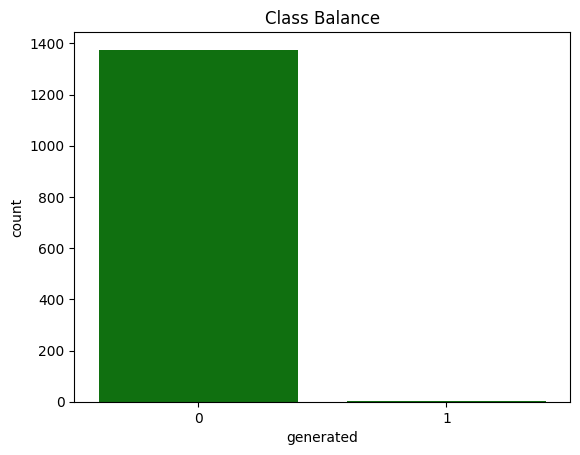

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='generated', data=essay_df, color='green')
plt.title('Class Balance')
plt.show()

### visualizing word coumts for the two classes

In [15]:
from wordcloud import WordCloud

human_text = ' '.join(essay_df[essay_df['generated'] == 0]['text'])
ai_text = ' '.join(essay_df[essay_df['generated'] == 1]['text'])

wordcloud_human = WordCloud(width=800, height=400, background_color='white').generate(human_text)
wordcloud_ai = WordCloud(width= 800, height=400, background_color='black').generate(ai_text)

#### displaying the human wordcloud

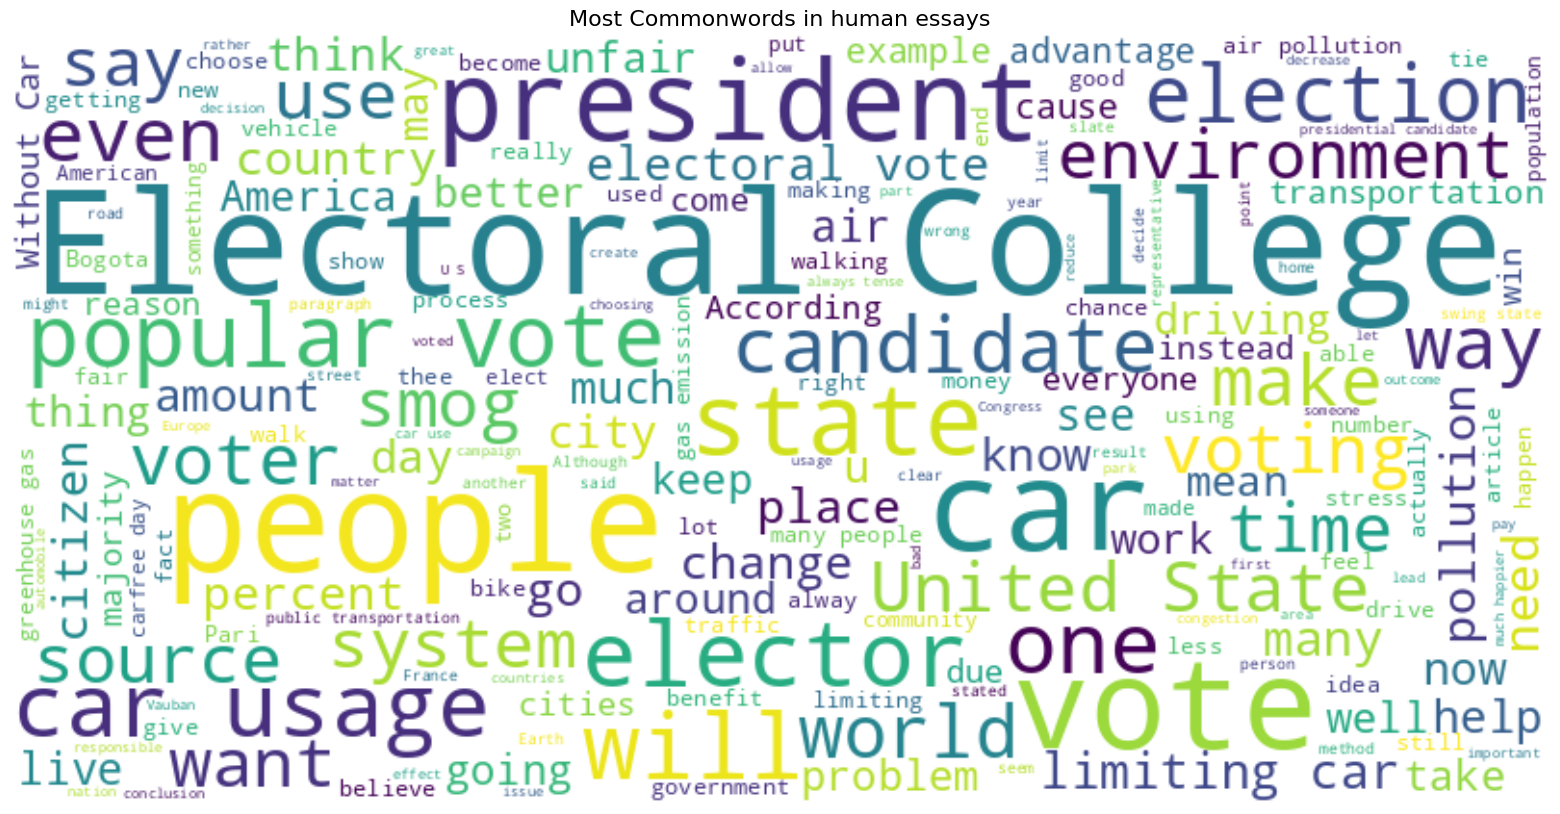

In [16]:
plt.figure(figsize=(20, 10))

plt.imshow(wordcloud_human, interpolation='bilinear')
plt.title('Most Commonwords in human essays', fontsize=16)
plt.axis('off')
plt.show()

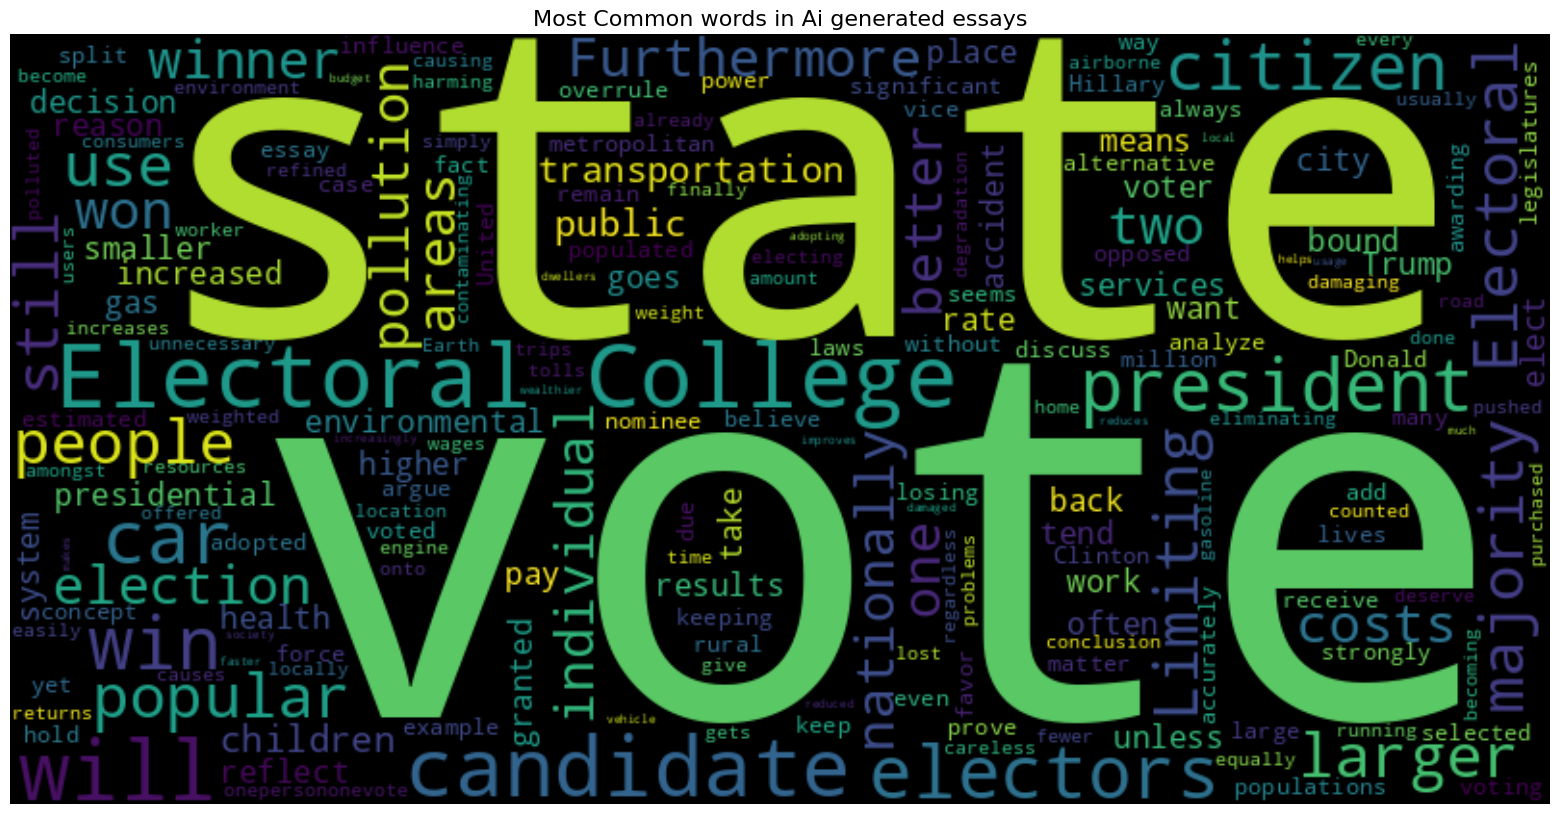

In [17]:
plt.figure(figsize=(20, 10))

plt.imshow(wordcloud_ai, interpolation='bilinear')
plt.title('Most Common words in Ai generated essays', fontsize=16)
plt.axis('off')
plt.show()

## 2. Displaying the distribution of essay lengths

the first part creates a new column word_count and then visualizes its distribution for both classes using a histogram

In [18]:
essay_df['word_count'] = essay_df['text'].str.split().str.len()

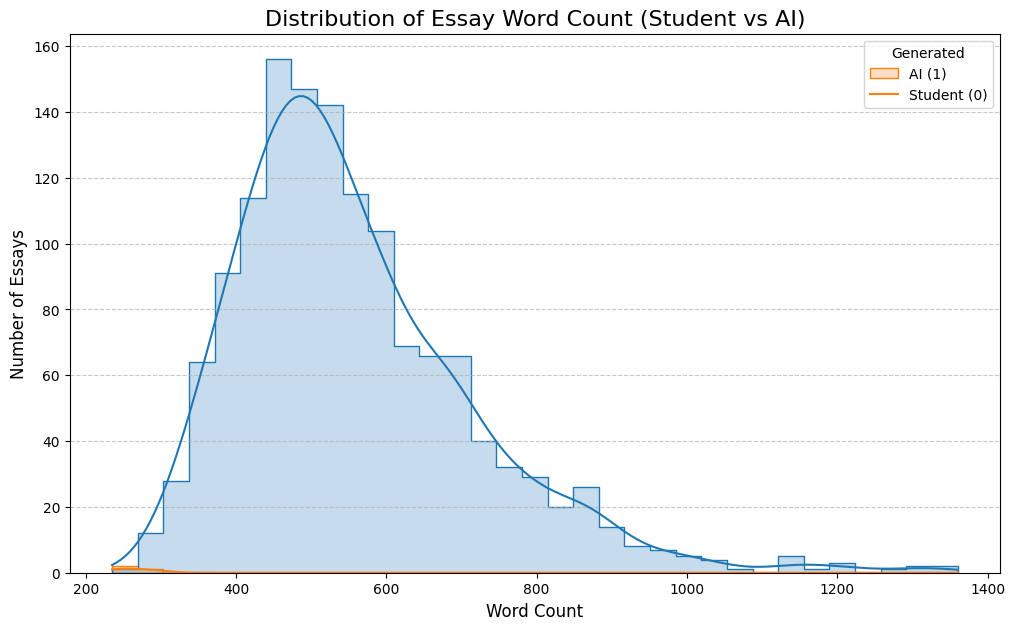

In [19]:
plt.figure(figsize=(12, 7))
sns.histplot(data=essay_df, x='word_count', hue='generated', kde=True, element='step')
plt.title('Distribution of Essay Word Count (Student vs AI)', fontsize=16)
plt.xlabel('Word Count', fontsize=12)
plt.ylabel('Number of Essays', fontsize=12)
plt.legend(title='Generated', labels=['AI (1)', 'Student (0)'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## Preprocessing
### removal of duplicated values, encodingm scaling, text processing, datetime features, feature enineering, dimensionality reduction

In [20]:
## dropping duplicates
essay_df = essay_df.drop_duplicates(subset=['text'])

In [21]:
print(essay_df.duplicated().sum())

0


In [22]:
essay_df.head(10)

,id,prompt_id,text,generated,word_count
0,0059830c,0,Cars. Cars have been around since they became ...,0,584
1,005db917,0,Transportation is a large necessity in most co...,0,462
2,008f63e3,0,"""America's love affair with it's vehicles seem...",0,744
3,00940276,0,How often do you ride in a car? Do you drive a...,0,686
4,00c39458,0,Cars are a wonderful thing. They are perhaps o...,0,871
5,00da8c32,1,The electrol college system is an unfair syste...,0,582
6,011dc2bc,1,"Dear state senator, It is the utmost respect t...",0,432
7,01448434,0,"Fellow citizens, cars have become a major role...",0,440
8,01c6e176,1,"""It's official: The electoral college is unfai...",0,471
9,0202ddf9,1,The Electoral College has been kept for centur...,0,569


### 2. Ecoding
Here, a tool called TfidfVectorizer will be used. It convert text into numbers based on how those number are important in each essay.   
**args:  
1. max-features=1000: keep only the 1000 most important words.
2. stop-words='english': ignore common words in the English language like is, or, and, the, etc.

X = tfidf.fit_transform(essay-df['text']).  
This goess through each essay and creating a row of numbers called the feature matrix. This feature matrix is assigned to X. Each row is one essay and column is one word

New Balanced Value Counts:
generated
0    1375
1    1375
Name: count, dtype: int64


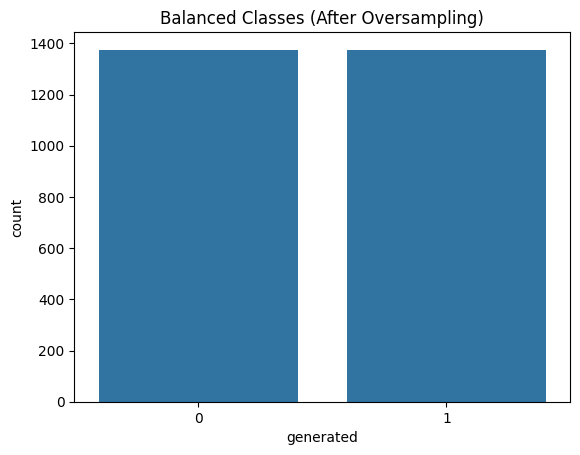

In [23]:
from sklearn.utils import resample

df_majority = essay_df[essay_df['generated'] == 0]
df_minority = essay_df[essay_df['generated'] == 1]

# Upsample the minority class to match the majority class
df_minority_oversampled = resample(df_minority,
                                 replace=True,     # Sample with replacement to make copies
                                 n_samples=len(df_majority), # Match the number of majority samples
                                 random_state=42)

# Combine the majority class with the upsampled minority class
df_balanced = pd.concat([df_majority, df_minority_oversampled])

# Display the new class balance
print("New Balanced Value Counts:")
print(df_balanced['generated'].value_counts())

sns.countplot(x='generated', data=df_balanced)
plt.title('Balanced Classes (After Oversampling)')
plt.show()

In [24]:
# cleanning the data to remvoe irrelevant/non-meaningfull words
import re
def clean_text(text):
  text = text.lower()
  text = re.sub(r'[^a-z\s]', '', text)
  text = re.sub(r'\s+', ' ', text).strip()
  return text

In [25]:
X = df_balanced['text']
y = df_balanced['generated']

In [26]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.3,
    random_state=42
)

In [27]:
X_train = X_train.to_frame()
X_test = X_test.to_frame()

In [28]:
X_train['clean_text'] = X_train['text'].apply(clean_text)
X_test['clean_text'] = X_test['text'].apply(clean_text)

converting text to features using TF-IDF

In [29]:
X_train

,text,clean_text
668,Dear Mr.Mrs. senator I believe that you should...,dear mrmrs senator i believe that you should c...
1262,"Limiting car use causes pollution, increases c...",limiting car use causes pollution increases co...
128,The usage of motor vehicles has been on a stea...,the usage of motor vehicles has been on a stea...
340,Dear senatoor of Florida. I am here tooday too...,dear senatoor of florida i am here tooday too ...
704,"This essay will analyze, discuss and prove one...",this essay will analyze discuss and prove one ...
...,...,...
1262,"Limiting car use causes pollution, increases c...",limiting car use causes pollution increases co...
1097,"Dear State Senator , I wrote this letter to yo...",dear state senator i wrote this letter to you ...
1132,We should abolish the Electoral College and ch...,we should abolish the electoral college and ch...
1297,"Dear State Senator, While I understand that th...",dear state senator while i understand that the...


In [30]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
tfidf_vectorizer = TfidfVectorizer(
    max_features=1000,
    stop_words='english',
    min_df=5,
    max_df=0.9
)

features_from_text_train = tfidf_vectorizer.fit_transform(X_train['clean_text']).toarray()
features_from_text_test = tfidf_vectorizer.transform(X_test['clean_text']).toarray()

print(f"Non-zero values:{np.count_nonzero(features_from_text_train)}")
print(f"Shape: {features_from_text_train.shape}")

feature_names = tfidf_vectorizer.get_feature_names_out()
print(feature_names[:20])

Non-zero values:181282
Shape: (1925, 1000)
['able' 'abolish' 'abolished' 'accident' 'accidents' 'according'
 'accurately' 'act' 'action' 'active' 'activists' 'actually' 'ad' 'add'
 'addition' 'adopted' 'adopting' 'advantage' 'advantages' 'affect']


In [31]:
features_from_text_test

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

scaling and feature reduction

In [32]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(features_from_text_train)
X_test_scaled = scaler.transform(features_from_text_test)

In [33]:
from sklearn.decomposition import PCA
pca = PCA(
    n_components=1
)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

showing diff correlations bet data:

In [35]:
features_from_textdf = pd.DataFrame(
    features_from_text_train,
    columns=feature_names
)
print(features_from_textdf.head(3))

       able  abolish  abolished  accident  accidents  according  accurately  \
0  0.045758      0.0        0.0  0.000000   0.000000        0.0         0.0   
1  0.000000      0.0        0.0  0.072301   0.068566        0.0         0.0   
2  0.000000      0.0        0.0  0.000000   0.000000        0.0         0.0   

   act  action  active  ...  wouldnt  written     wrong  wyoming      year  \
0  0.0     0.0     0.0  ...      0.0      0.0  0.046369      0.0  0.000000   
1  0.0     0.0     0.0  ...      0.0      0.0  0.000000      0.0  0.000000   
2  0.0     0.0     0.0  ...      0.0      0.0  0.000000      0.0  0.040703   

      years  yes  york  young  youre  
0  0.000000  0.0   0.0    0.0    0.0  
1  0.000000  0.0   0.0    0.0    0.0  
2  0.038153  0.0   0.0    0.0    0.0  

[3 rows x 1000 columns]


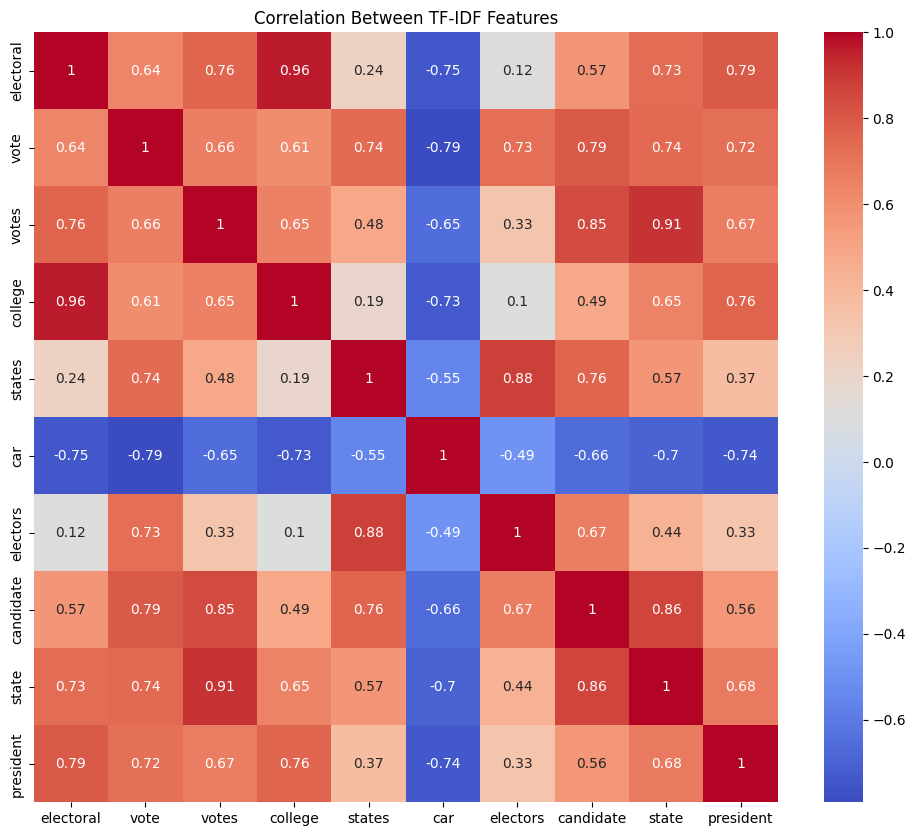

In [36]:
top10words = features_from_textdf.mean().sort_values(ascending=False).head(10).index.tolist()
correlation_matrix1 = features_from_textdf[top10words].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix1, cmap='coolwarm', annot=True)
plt.title("Correlation Between TF-IDF Features")
plt.show()

In [37]:
import plotly.express as px

top_20_words = features_from_textdf.mean().sort_values(ascending=False).head(20)

fig = px.bar(
    x=top_20_words.values,
    y=top_20_words.index,
    labels={'x': 'Avg TF-IDF Score', 'y': 'Word'},
    title='Top 20 Most Important Words (by Average TF-IDF Score)',
    color=top_20_words.values,
    color_continuous_scale='Viridis'
)

fig.show()

# Training the MLPClassifier Model

In [38]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score

param_grid = {
    'hidden_layer_sizes': [(10,), (50,), (64, 32), (64,32,16)],
    'activation': ['relu', 'logistic'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate_init': [0.001, 0.01]
}

base_mlp = MLPClassifier(
    max_iter=200,
    early_stopping=True,
    random_state=42
)

grid_search = GridSearchCV(
    base_mlp, param_grid, cv=5,
    n_jobs=-1, verbose=1, scoring='accuracy'
)

grid_search.fit(X_train_pca, y_train)
best_model = grid_search.best_estimator_
print(f"best hyperparamters: {grid_search.best_params_}")

Fitting 5 folds for each of 48 candidates, totalling 240 fits
best hyperparamters: {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (64, 32), 'learning_rate_init': 0.01}


In [39]:
final_model = MLPClassifier(activation='relu', alpha=0.0001, hidden_layer_sizes=[64,32], learning_rate_init=0.01, verbose=1).fit(X_train_pca, y_train)

Iteration 1, loss = 0.60227214
Iteration 2, loss = 0.48354355
Iteration 3, loss = 0.39813204
Iteration 4, loss = 0.35933376
Iteration 5, loss = 0.34546019
Iteration 6, loss = 0.35215778
Iteration 7, loss = 0.35549670
Iteration 8, loss = 0.34716509
Iteration 9, loss = 0.34199923
Iteration 10, loss = 0.33590934
Iteration 11, loss = 0.34305411
Iteration 12, loss = 0.35141669
Iteration 13, loss = 0.33647219
Iteration 14, loss = 0.32507306
Iteration 15, loss = 0.35525818
Iteration 16, loss = 0.34481606
Iteration 17, loss = 0.34219436
Iteration 18, loss = 0.33747780
Iteration 19, loss = 0.33017685
Iteration 20, loss = 0.32725410
Iteration 21, loss = 0.32140194
Iteration 22, loss = 0.32421250
Iteration 23, loss = 0.32159112
Iteration 24, loss = 0.31766605
Iteration 25, loss = 0.30639630
Iteration 26, loss = 0.29629755
Iteration 27, loss = 0.29070918
Iteration 28, loss = 0.29191708
Iteration 29, loss = 0.29930512
Iteration 30, loss = 0.31067994
Iteration 31, loss = 0.30688952
Iteration 32, los

In [40]:
print(f"accuracy score: {final_model.score(X_test_pca, y_test)}")

accuracy score: 0.7842424242424243



Test Accuracy: 0.9200
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.84      0.91       410
           1       0.86      1.00      0.93       415

    accuracy                           0.92       825
   macro avg       0.93      0.92      0.92       825
weighted avg       0.93      0.92      0.92       825

Cross-validation scores (5-fold): [0.9038961  0.92727273 0.92987013 0.92467532 0.91688312]
Mean CV Accuracy: 0.9205


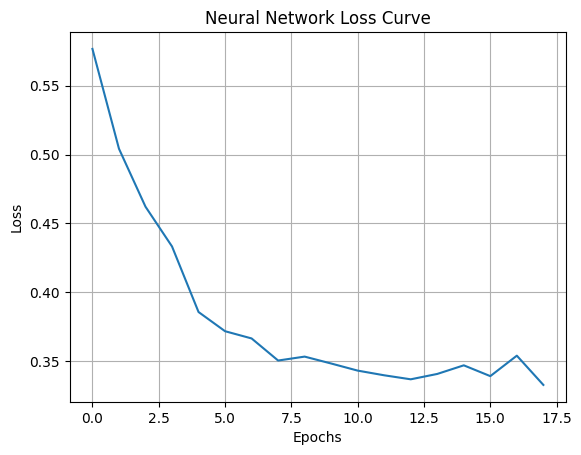

 Best model saved as 'best_nn_model.pkl'


In [41]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report , ConfusionMatrixDisplay
import joblib
# Step 5: Evaluate on test set
y_predNN = best_model.predict(X_test_pca)
acc = accuracy_score(y_test, y_predNN)
print(f"\nTest Accuracy: {acc:.4f}")
print("Classification Report:")
print(classification_report(y_test, y_predNN))

# Step 6: Cross-validation on training set
cv_scores = cross_val_score(best_model, X_train_pca, y_train, cv=5, scoring='accuracy')
print(f"Cross-validation scores (5-fold): {cv_scores}")
print(f"Mean CV Accuracy: {cv_scores.mean():.4f}")

# Step 7: Plot loss curve
plt.plot(best_model.loss_curve_)
plt.title("Neural Network Loss Curve")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

# Step 8: Save the best model
joblib.dump(best_model, "best_nn_model.pkl")
print(" Best model saved as 'best_nn_model.pkl'")